# Supplementary Figure 9

---

<br>

## Import libraries

In [1]:
# scientific libraries
import pandas as pd
import numpy as np

# sequence management
import pysam

# plotting libraries
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

## Opening Dataset file

In [4]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

---

<br>

# Method for evaluating base quality

In [5]:
# Function for averaging values from a nested list

def avgNestedLists(nested_vals):
    """
    Averages a 2-D array and returns a 1-D array of all of the columns
    averaged together, regardless of their dimensions.
    """
    output = []
    maximum = 0
    for lst in nested_vals:
        if len(lst) > maximum:
            maximum = len(lst)
    
    for index in range(maximum): # Go through each index of longest list
        temp = []
        for lst in nested_vals: # Go through each list
            if index < len(lst): # If not an index error
                temp.append(lst[index])
        output.append(np.nanmean(temp))
    return output

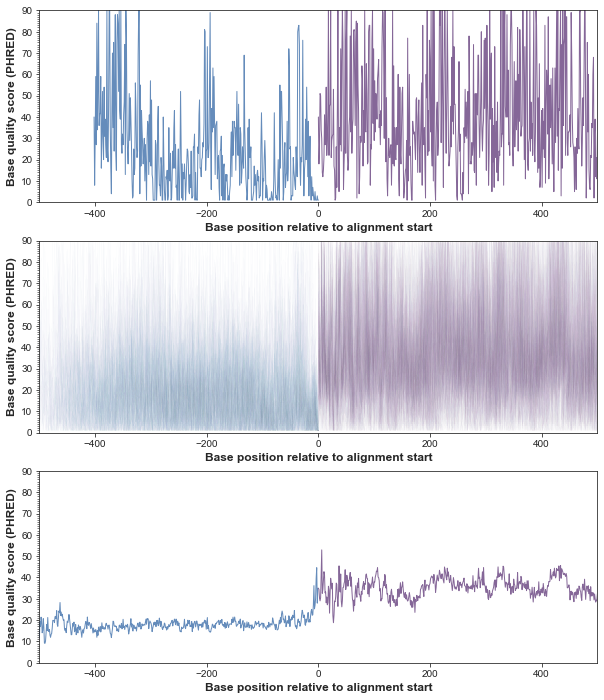

In [8]:
# open alignment file to process
aln_file = f'{path}/SSP_1/SSP_1-transcriptome_sorted.bam'
alignment = pysam.AlignmentFile(aln_file,'rb')


# select randomly 10K reads

# conditions:
# - antisense reads
# - long 5' soft clip
_selected = dataset[(dataset['run']=='SSP_1') & (dataset['read_orientation']=='antisense') &  (dataset['softclip']==1) & (dataset['gene']=='F40F8.10')]
selected_reads = list(_selected.sample(n=500)['read'])


# plot

%matplotlib inline

sns.set_style('ticks', {'axes.edgecolor': '.15', 'axes.linewidth': '1.5', "xtick.major.size": 8, "ytick.major.size": 8, "xtick.minor.size": 5, "ytick.minor.size": 5})
fig, ax = plt.subplots(figsize=(10,12), ncols=1, nrows=3)


# start looping over alignment
# plot 1 read in top panel
# plot 10K superposed reads in middle panel
# plot averaged mean in bottom panel

ALIGNED = []
UNALIGNED = []
total = 0
max_iter = len(selected_reads)

for read in alignment:

    # only look primary alignments
    if not read.is_unmapped and not read.is_secondary and not read.is_supplementary and read.seq is not None:
        
        if not read.query_name in selected_reads:
            continue
        
        else:
            
            quali = read.query_qualities
            start = read.query_alignment_start
            end = read.query_alignment_end
            
            # counter to check total number of reads processed
            total = total+1
            
            # aligned region
            aligned = list(quali[start:end])
            xAligned = [i for i in range(0, len(aligned))]
            
            # unaligned (= softclip) region
            unaligned = list(quali[:start+1])
            xUnaligned = [i for i in range(-len(unaligned)+1, 1)]

            # append qualities lo list for computting mean values
            ALIGNED.append(aligned)
            _unaligned = unaligned # need to be copied to another variable 
            _unaligned.reverse()   # then modified so it doesn't impact plotting on middle panel
            UNALIGNED.append(_unaligned)

            if total == 25:
                
                ax[0].plot(xAligned, aligned, color='#856798', alpha=1, label='Aligned region',linewidth=1)
                ax[0].plot(xUnaligned, unaligned, color='#658cbb', alpha=1, label='Unaligned region',linewidth=1)
            
            elif total <= 100:


                ax[1].plot(xAligned, aligned, color='#856798', alpha=0.2, label='Aligned region', linewidth=0.05)
                ax[1].plot(xUnaligned, unaligned, color='#658cbb', alpha=0.2, label='Unaligned region', linewidth=0.05)
            
            elif total > 100:
                break
            
            elif total > max_iter:
                print('Finished looping over reads - now computing mean base quality')
                break

### compute mean values for bottom panel and plot

# averaged values
avgAligned = avgNestedLists(ALIGNED)

avgUnaligned = avgNestedLists(UNALIGNED)
avgUnaligned.reverse()

# base quality on Y axis
avg = avgUnaligned + avgAligned

# X axis values (= base position relative to alignment start)
xMeanUnaligned = [i for i in range(-len(avgUnaligned), 1)]
xMeanAligned = [i for i in range(0, len(avgAligned))]

# Y axis values (= average value)
yMeanUnaligned = avg[:len(avgUnaligned)+1]
yMeanAligned = avg[len(avgUnaligned):]

# plotting
ax[2].plot(xMeanUnaligned, yMeanUnaligned, color='#658cbb', alpha=1, label='Unaligned region', linewidth=1)
ax[2].plot(xMeanAligned, yMeanAligned, color='#856798', alpha=1, label='Aligned region', linewidth=1)

#### axis settings

for i in [0,1,2]:
    
    ax[i].set_ylim(0, 90)
    ax[i].set_xlim(-500,500)
    ax[i].set_xlabel('Base position relative to alignment start', weight='bold', size=12)
    ax[i].set_ylabel('Base quality score (PHRED)', weight='bold', size=12)
    ax[i].tick_params(axis='x', which='major', bottom=True)
    ax[i].tick_params(axis='y', which='both', left=True)
    ax[i].yaxis.set_minor_locator(MultipleLocator(1))

plt.savefig('SupFig9-base_quality_method.pdf', dpi=300, bbox_inches='tight')

<font size="4">**Sup. Fig. 9:**<br></font>
Method for evaluating base quality. Single read’s base quality contains too much variability
for accurate measurement (**top panel**). Trends in base quality can be observed when looking at larger
samples of reads (**middle panel** - 100 reads shown together). Averaging the base quality per position
across a large sample of reads (**bottom panel**) allows to accurately visualize differences in base quality
between different regions of the reads. Unaligned 5’ soft-clip region is shown in blue and alignment region
in purple.